## Distributed Linear Algebra Project - HPC-AI Mines Paristech

---

#### BOURBON Benjamin
#### VITAL Eduardo
---

# 2D Poisson problem

We are interested in the 2D Poisson problem whose equation's follows :

$$
- \Delta u(x,y) + \sigma u(x, y) = f(x, y) \text{ in } \Omega \quad \sigma \ge 0
$$
$$
u(x, y) = 0 \text{ on } \partial \Omega
$$

To solve this equation, we are using discretization to transform continuous functions, models and variables into discrete counterparts. Let's decompose this equation :

$$
- \Delta u(x, y) = - \frac{\partial^2 u(x, y)}{\partial x^2} - \frac{\partial^2 u(x, y)}{\partial y^2}
$$

We discretize them :

$$
\frac{\partial u(x, y)}{\partial x} \approx \frac{u(x_{i + 1}, y_i) - u(x_i, y_i)}{h} \quad \text{and} \quad \frac{\partial u(x, y)}{\partial y} \approx \frac{u(x_i, y_{i + 1}) - u(x_i, y_i)}{h}
$$

Then :

$$
\begin{align}
\frac{\partial^2 u(x, y)}{\partial x^2} & \approx \frac{\frac{u(x_{i + 1}, y_i) - u(x_i, y_i)}{h} - \frac{u(x_i, y_i) - u(x_{i - 1}, y_i)}{h}}{h} \\
                                        & = \frac{u(x_{i + 1}, y_i) - 2 u(x_i, y_i) + u(x_{i - 1}, y_i)}{h^2}
\end{align}
$$

and

$$
\begin{align}
\frac{\partial^2 u(x, y)}{\partial y^2} & \approx \frac{\frac{u(x_i, y_{i + 1}) - u(x_i, y_i)}{h} - \frac{u(x_i, y_i) - u(x_i, y_{i - 1})}{h}}{h} \\
                                        & = \frac{u(x_i, y_{i + 1}) - 2 u(x_i, y_i) + u(x_i, y_{i - 1})}{h^2}
\end{align}
$$

Thus :

$$
- \Delta u(x, y) + \sigma u(x, y) \approx \frac 1 {h^2} \left[(4 + h^2 \sigma) \ u(x_i, y_i) - u(x_{i+1}, y_i) - u(x_i, y_{i+1}) - u(x_{i - 1}, y_i) - u(x_i, y_{i - 1}) \right]
$$

In other words, we can define the following matrix $A$:

$$
A =
\begin{pmatrix}
B                 & -\frac 1 {h^2} I  & 0      & \dots            & 0                \\
-\frac 1 {h^2} I  & \ddots            & \ddots & \ddots           & \vdots           \\
0                 & \ddots            & \ddots & \ddots           & 0                \\
\vdots            & \ddots            & \ddots & \ddots           & -\frac 1 {h^2} I \\
0                 & \dots             & 0      & -\frac 1 {h^2} I & B                \\
\end{pmatrix}
$$

where :
- $B$ is the $\frac 1 {h^2} \text{tridiag}(-1, (4 + h^2) \sigma, -1)$ ($n \times n$ matrix)
- $I$ is a $n \times n$ identity matrix
- $A$ is a $n^2 \times n^2$ matrix


# Anisotropic problem

We are interested to solve the following equation :

$$
- \frac{\partial^2 u(x, y)}{\partial x^2} - \epsilon \frac{\partial^2 u(x, y)}{\partial y^2} = f(x, y) \text{ in } \Omega
$$
$$
u(x, y) = 0 \text{ on } \partial \Omega
$$

With the same idea, we use discretization and get the following matrix $A$:

$$
- \frac{\partial^2 u(x, y)}{\partial x^2} - \epsilon \frac{\partial^2 u(x, y)}{\partial y^2} \approx \frac 1 {h^2} \left[2(1 + \epsilon) \ u(x_i, y_i) - u(x_{i+1}, y_i) - \epsilon u(x_i, y_{i+1}) - u(x_{i - 1}, y_i) - \epsilon u(x_i, y_{i - 1}) \right]
$$


$$
A =
\begin{pmatrix}
C                        & -\frac \epsilon {h^2} I    & 0                       & \dots          & 0                \\
-\frac \epsilon {h^2} I  & \ddots            & \ddots & \ddots                  & \vdots           \\
0                        & \ddots            & \ddots & \ddots                  & 0                \\
\vdots                   & \ddots            & \ddots & \ddots                  & -\frac \epsilon {h^2} I \\
0                        & \dots             & 0      & -\frac \epsilon {h^2} I & C                \\
\end{pmatrix}
$$

where :
- $C$ is the $\frac 1 {h^2} \text{tridiag}(-1, 2 (1 + \epsilon), -1)$ ($n \times n$ matrix)
- $I$ is a $n \times n$ identity matrix
- $A$ is a $n^2 \times n^2$ matrix


# Multigrid method

We will apply the multigrid method to solve problems because it provides an algorithm for solving differential equations using a hierarchy of discretizations.
There are several steps to follow :
- **Smoothing** – reducing high frequency errors; done early (Presmoothing) and later (Postsmoothing) in the algorithm.
- **Restriction** – downsampling the residual error to a coarser grid.
- **Solve** - directly or indirectly compute the solution on the coarser grid.
- **Interpolation** or **prolongation** – interpolating a correction computed on a coarser grid into a finer grid.
- **Correction** – Adding prolongated coarser grid solution onto the finer grid.

The Multi-grid algorithm allows to perform, at each iteration, a whole cycle. The forms of cycle developed, as we are going to see, can be V-cycle or W-cycle. For each one, the depth parameter `l` define how many times the grid will be reduced to a coarser one in order to compute the solution.

In [1]:
# all imports
from time import perf_counter as pf
from math import pi, sin, cos, sqrt, log
from itertools import product
from statistics import mean
from copy import copy
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from numpy import concatenate as conc
import numpy as np
import scipy as sp
from scipy import sparse
import scipy.linalg as la

In [2]:
# Some global parameters
EPS = 1e-4
MAXITER = 100

In [3]:
# General help functions
def _basic_check(A, b, x0):
    """Common check for clarity"""
    n, m = A.shape
    if n != m:
        raise ValueError("Only square matrix allowed")
    elif b.size != n:
        raise ValueError("Bad rhs size")
    if x0 is None:
        x0 = np.zeros(n)
    elif x0.size != n:
        raise ValueError("Bad initial value size")
    return x0

def smart_array(function: callable, max_i: int, max_j: int) -> np.array:
    """
    Concatenate a matrix of matrices

    Parameters :
        function : callable(int, int) -> np.array
        max_i : number of rows
        max_j : number of columns
    """
    return conc([conc([function(i, j) for j in range(max_j)], axis=1) for i in range(max_i)])

def tridiag(a, b, c, k1=-1, k2=0, k3=1):
    """
    Return a tridiagonal matrix
    """
    return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)

def A_matrix(n, epsilon):
    """
    Return a matrix to compute the matrix of anisotropic 2D Poisson problem
    """
    return tridiag([-1] * (n - 1), [2 * (1 + epsilon)] * n, [-1] * (n - 1))

def B_matrix(n, hsigma):
    """
    Return the B matrix to compute the matrix of 2D Poisson problem
    """
    return tridiag([-1] * (n - 1), [4 + hsigma] * n, [-1] * (n - 1))

The next function creates the matrix $A$ for the 2D Poisson problem `laplace(n, h, sigma=value)` or the anisotropic problem `laplace(n, h, epsilon=value)`. 

In [4]:
# 2D Poisson matrix function
def laplace(n, h, sigma=None, epsilon=None, **kwargs):
    """
    Return the matrix of 2D Poisson problem
    """
    assert not (sigma is None and epsilon is None), "sigma or epsilon must be defined"
    assert not (
        sigma is not None and epsilon is not None
    ), "only one of values sigma and epsilon must be defined"
    Z = np.zeros((n, n)) # zero matrix
    if sigma is not None:
        I = np.diag([-1] * n, 0) # identity matrix
        C = B_matrix(n, h * h * sigma) # laplace matrix
    elif epsilon is not None:
        I = epsilon * np.diag([-1] * n, 0) # identity matrix
        C = A_matrix(n, epsilon) # laplace matrix

    def choose(i, j):
        if i == j:
            return C
        elif abs(i - j) == 1:
            return I
        else:
            return Z

    return smart_array(choose, n, n) / (h * h)

Restriction – downsampling the residual error to a coarser grid. Three approachs were developed:
![Restriction](images/restriction.png)

In [5]:
# Restriction functions
def injection(fine, coarse=None):
    """
    Classical injection, that only keep the value of the coarse nodes
    The modification of coarse is done inplace
    """
    h, w = fine.shape
    return np.array([[fine[i, j] for j in range(w) if j % 2] for i in range(h) if i % 2])

def half_weighting(fine, coarse=None):
    """
    Classical half weighting, that only keep the value of the coarse nodes
    The modification of coarse is done inplace
    """
    h, w = fine.shape
    indexes = ((-1, -1), (-1, 0), (0, 0), (1, 0), (1, 1))
    coeff = lambda di, dj: 1 if di or dj else 4

    def restrict(i, j):
        values = (fine[i + di, j + dj] * coeff(di, dj) for (di, dj) in indexes)
        return sum(values) / 8

    return np.array([[restrict(i, j) for j in range(w) if j % 2] for i in range(h) if i % 2])

def full_weighting(fine, coarse=None):
    """
    Classical full weighting, that only keep the value of the coarse nodes
    The modification of coarse is done inplace
    """
    h, w = fine.shape
    coeff = lambda di, dj: (1 + bool(not (di))) * (1 + bool(not (dj)))
    indexes = tuple(product(range(-1, 2), range(-1, 2)))

    def restrict(i, j):
        values = (fine[i + di, j + dj] * coeff(di, dj) for (di, dj) in indexes)
        return sum(values) / 16

    return np.array([[restrict(i, j) for j in range(w) if j % 2] for i in range(h) if i % 2])

Interpolation or prolongation – interpolating a correction computed on a coarser grid into a finer grid.
![Interpolation](images/interpolation.png)

In [6]:
# Interpolation function
def interpolation(coarse, fine=None):
    """
    Classical 2D linear interpolation (the modification of fine is done inplace)
    """
    h, w = coarse.shape

    def interpolate(i, j):
        qi, ri = divmod(i, 2)
        qj, rj = divmod(j, 2)

        if rj:
            if ri:
                return coarse[qi, qj]
            elif qi == 0:
                return mean([coarse[qi, qj], 0]) # border case
            elif qi == h:
                return mean([coarse[qi - 1, qj], 0]) # border case
            else:
                return mean([coarse[(i - 1) // 2, qj], coarse[i // 2, qj]])
        elif ri:
            if qj == 0:
                return mean([coarse[qi, qj], 0]) # border case
            elif qj == w:
                return mean([coarse[qi, qj - 1], 0]) # border case
            else:
                return mean([coarse[qi, (j - 1) // 2], coarse[qi, j // 2]])
        else:
            a = 0 if qi == 0 or qj == 0 else coarse[qi - 1, qj - 1]
            b = 0 if qi == 0 or qj == w else coarse[qi - 1, qj]
            c = 0 if qi == h or qj == 0 else coarse[qi, qj - 1]
            d = 0 if qi == h or qj == w else coarse[qi, qj]
            return mean([a, b, c, d])

    return np.array([[interpolate(i, j) for j in range(2 * w + 1)] for i in range(2 * h + 1)])

---
Functions for smoothing and correction.

In [7]:
def JOR(A, b, x0=None, omega=0.5, eps=EPS, maxiter=MAXITER):
    norm = np.linalg.norm
    inv = np.linalg.inv
    n = A.shape[0]
    x = _basic_check(A, b, x0)
    invM = sparse.csr_matrix(inv(np.diag(np.diag(A)) / omega))
    nr = norm(b - A @ x)
    residual_history = [nr]
    A = sparse.csr_matrix(A)
    i = 0
    while residual_history[-1] > eps and i <= maxiter:  # EPS et MAXITER
        r = b - (A @ x).reshape((n,))
        residual_history.append(norm(r) / nr)
        x += invM @ r
        i += 1

    return x, residual_history[1:]

def SOR(A, b, x0=None, omega=1.5, eps=EPS, maxiter=MAXITER):
    if (omega > 2.0) or (omega < 0.0):
        raise ArithmeticError("SOR will diverge")

    norm = np.linalg.norm
    inv = np.linalg.inv
    x = _basic_check(A, b, x0)
    r = np.zeros(x.shape)
    n = A.shape[0]
    residual_history = []
    E = np.tril(A)
    M = np.diag(A) / omega + E
    invM = sparse.csr_matrix(inv(np.diag(np.diag(A)) / omega))
    nr = norm(b - A @ x)
    residual_history = [nr]
    A = sparse.csr_matrix(A)
    i = 0
    while residual_history[-1] > eps and i <= maxiter:  # EPS et MAXITER
        r = b - (A @ x).reshape((n,))
        residual_history.append(norm(r) / nr)
        x += invM @ r
        i += 1

    return x, residual_history[1:]

---
Functions to configure or initialize the solution. The grid functions are used to generate an initial guess for the solution `u`, while the `f` functions represent the $f(x, y)$ from the equation.

In [8]:
def grid_sinx(x_grid, y_grid):
    """
    Initialize u to a sinusoidal form in x and repeat it along the y axis
    """
    u0 = 0.5 * (np.sin(16.0 * x_grid * pi) + np.sin(40.0 * x_grid * pi))
    u0 = u0.repeat(u0.size)
    return u0

def grid_0(x_grid, y_grid):
    """
    Initialize u to a uniform vector of 0
    """
    return np.zeros(int(x_grid.size**2))

def grid_sinxy(x_grid, y_grid):
    """
    Initialize u to a sinusoidal form depending of x and y
    """
    return np.array([sin(16 * x * pi) + sin(16 * y * pi) for x in x_grid for y in y_grid])

def uniform_f(x_grid, y_grid):
    """
    Initialize f to a uniform vector
    """
    return 10.0 * np.ones(x_grid.size**2)

def sinx_f(x_grid, y_grid):
    """
    Initialize f to a sinusoidal form in x and repeat it along the y axis
    """
    return 10 * np.array([sin(3 * x * pi) for x in x_grid for y in y_grid])

---
Helper classes to store the result/solution and residus outuputted from the algorithm and plot it.

In [9]:
class Result:
    """
    Class to store result of the function `multigrid`
    
    Attributs
    ---------
        - u0 :       np.array, initial values of unknown solution
        - solution : np.array, solution
        - residues : list of residues of each cycle
    """
    
    def __init__(self, u0=None, solution=None, residues=None):
        self.u0 = u0 if u0 is not None else np.array([])
        self.solution = solution if solution is not None else np.array([])
        self.residues = residues if residues is not None else []
    
    def __str__(self):
        return (
            f"Result[\n\tu0=<np.array(shape={self.u0.shape})>,"
            + f"\n\tsolution=<np.array(shape={self.solution.shape})>,"
            + f"\n\tresidues={self.residues}\n]"
        )
        
    def show(self, display = True, residues = True):
        """
        Plot and show results
        
        Parameters
        ----------
            - display  : bool, if True, show a 3D projection of initial values and final solution
            - residues : bool, if True, show the evolution of residues
        """
        if display:
            fig, ax_3d = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={"projection": "3d"})
            for i, (z, title) in enumerate(zip((self.u0, self.solution), ("Inital vector", "Final result"))):
                ax = ax_3d[i]
                shape1d = int(sqrt(z.size))
                z = z.reshape((shape1d, shape1d))
                mesh1d = np.linspace(0.0, 1.0, shape1d)
                X, Y = np.meshgrid(mesh1d, mesh1d)

                ax.plot_surface(X, Y, z, cmap=cm.coolwarm)
                ax.set_title(title)
                ax.set_xlabel("$x$")
                ax.set_ylabel("$y$")
                ax.set_zlabel("$u(x)$")
            plt.show()
        if residues:
            fig2, ax_res = plt.subplots(1, 2, figsize=(12, 6))
            ax_res[0].plot(self.residues)
            ax_res[0].set_xlabel("Iterations")
            ax_res[0].set_ylabel("Residues")
            ax_res[0].set_title("Evolution of residues")
            ax_res[1].plot(np.log(self.residues))
            ax_res[1].set_xlabel("Iterations")
            ax_res[1].set_ylabel("Residues (log)")
            ax_res[1].set_title("Evolution of residues (log)")
            plt.show()
    
    def join(self, axes, label):
        """
        Method useful to add `residues` values on a graph
        """
        ax[0].plot(self.residues, label=label)
        ax[1].plot([np.log(x) for x in self.residues], label=label)
        
class OneCycle:    
    """
    Class to store result of the function `tgcyc`
    
    Attributs
    ---------
        - display  : dict, - key   : tuple[int, int], indexes useful to plot a 3D projection
                           - values: tuple[np.array, str], values of unknowns, title of the graph 
        - cycles   : list, list of indexes to plot a cycle
        - solution : np.array, array which contains value of the solution of `tgcyc`
    """
    
    def __init__(self, display=None, cycles=None, solution=None):
        self.display = display if display is not None else {}
        self.cycles = cycles if cycles is not None else [[1, 1]]
        self.solution = solution if solution is not None else np.array([])

    def __str__(self):
        iterator = (
            f"{key}:(<np.array(shape={u.shape}>, title={repr(title)})"
            for key, (u, title) in zip(self.display.keys(), self.display.values())
        )
        repr_display = "{\n\t\t" + ", \n\t\t".join(iterator) + "\n\t}"
        return (
            f"OneCycle[\n\tdisplay={repr_display}],"
            + f"\n\tcycles={self.cycles},"
            + f"\n\tsolution=<np.array({self.solution.shape})>\n]"
        )

    def update(self, side):
        """Update cycles"""
        a, b = self.cycles[-1]
        self.cycles.append([a + abs(side), b - side])

    def show(self, display=True, cycles=False):
        """
        Plot and show results
        
        Parameters
        ----------
            - display  : bool, if True, show a 3D projection of steps of one cycle
            - cycles : bool, if True, show the graph of cycles
        """
        if display:
            fig, ax_3d = plt.subplots(2, 3, figsize=(18, 12), subplot_kw={"projection": "3d"})
            for key in self.display:
                i, j = key
                z, title = self.display[key]
                ax = ax_3d[key]

                shape1d = int(sqrt(z.size))
                z = z.reshape((shape1d, shape1d))
                mesh1d = np.linspace(0.0, 1.0, shape1d)
                X, Y = np.meshgrid(mesh1d, mesh1d)

                ax.plot_surface(X, Y, z, cmap=cm.coolwarm)
                ax.set_title(title)
                ax.set_xlabel("$x$")
                ax.set_ylabel("$y$")
                ax.set_zlabel("$u(x)$")
            plt.show()

        if cycles:
            plt.figure(figsize=(8, 4))
            max_ = max(self.cycles, key=lambda e: e[1])[1]
            min_ = min(self.cycles, key=lambda e: e[1])[1]
            floors = max_ - min_ + 1
            x, y = np.array(self.cycles).T
            colors = np.array(["g"] * len(self.cycles))
            colors[np.where(y == y.min())] = "r"
            plt.scatter(x, y, edgecolors="black", s=100, c=colors)
            plt.plot(x, y, "black")
            myticks = ["$\\Omega^{" + str(2**i) + "h}$" for i in range(floors)][::-1]
            plt.yticks(list(range(min_, max_ + 1)), myticks)
            plt.rc('ytick', labelsize=20)
            plt.title("Grid cycle scheme")
            plt.xticks([])
            plt.show()
            plt.rcParams.update(plt.rcParamsDefault)

---
Multi-grid algorithm for a single cycle; the residue is calculated only at the end of the cycle.

In [10]:
def tgcyc_recursive(
    l, nsegment, f, engine=JOR, nu1=3, nu2=3, gamma=1, restriction=injection, u0=grid_0, result=None, **kwargs
):
    """
    Parameters
    ----------
        l(int):               depth of the cycle.
        nsegment(int):        discretization parameter.
        f(callable or array): function defining the right side of the equation: f(x, y). 
                              It is passed as an array only intenally.
        nu1, nu2 (int):       number of presmothing and postsmoothing iterations.
        gamma(int):           defines the type of cycle; 1 = V-cycle and 2 = W-Cycle.
        u0(callable):         function to determine the initial guess for the solution in a 2D grid.
        result(class):        stores the results of the algorithm.
        
        **kwargs: sigma(float):          used in the standard problem. If passed, epsilon should not also be passed.
                  epsilon(float):        used in anisotropic problem. If passed, sigma should not also be passed.
                  restriction(callable): function to perform the injection: 
                                         'injection', 'half-weighting', full-weithing.
    """
    main_loop = callable(f)
    
    if nsegment % 2:
        raise ValueError("nsegment must be even")

    # Beware that : nsegment
    # n = number of nodes
    # n_unknown = number of unknowns
    n = nsegment + 1
    n_unknown = nsegment - 1
    h = 1.0 / nsegment
    H = 2.0 * h

    # construction of Laplace operator
    Ah = laplace(n_unknown, h, **kwargs)
    AH = laplace(n_unknown // 2, H, **kwargs)

    # Initial guess
    if main_loop:
        # Full points
        xh = np.linspace(0.0, 1.0, n)
        xH = np.linspace(0.0, 1.0, n // 2 + 1)

        # Inner points
        xih = xh[1:-1]
        xiH = xH[1:-1]
        u0 = u0(xih, xih) if callable(u0) else u0
        f = f(xih, xih)
        result.display[(0, 0)] = (u0, "Initial vector")
    
    # Pre-smoothing Relaxation
    u, _ = engine(Ah, f, x0=u0.copy(), maxiter=nu1)
    
    if main_loop:
        result.display[(0, 1)] = (u, "Smoothing relaxation")

    dh = f - sparse.csr_matrix(Ah) @ u
    
    # Restriction with injection
    dH = restriction(dh.reshape((n_unknown, n_unknown))).flatten()
    result.update(1)

    if main_loop:
        result.display[(0, 2)] = (u, "Restriction")

    # Solve on the coarse grid
    if l == 1:
        vH = np.linalg.solve(AH, dH)
        result.update(0)
    else:
        for i in range(gamma):
            vH = np.zeros(dH.size) if i == 0 else vH
            vH = tgcyc_recursive(
                l=l - 1, nsegment=int(sqrt(dH.size) + 1), f=dH.copy(), gamma=gamma, 
                engine=engine, nu1=nu1, nu2=nu2, u0=vH.copy(), result=result, **kwargs,
            ).solution

            
    if main_loop:
        result.display[(0, 2)] = (vH, "Solve")

    # Prolongation
    vh = interpolation(vH.reshape((-1, int(sqrt(vH.size)))))
    result.update(-1)

    if main_loop:
        result.display[(1, 0)] = (vh, "Prolongation")

    vh = vh.flatten()

    # Update solution
    uh = u + vh

    if main_loop:
        result.display[(1, 1)] = (uh, "Update solution")

    # Post-smoothing Relaxation
    u, _ = engine(Ah, f, x0=uh.copy(), maxiter=nu2)

    if main_loop:
        result.res = np.linalg.norm(f - Ah @ u)
        result.u0 = u.copy() # useful for `multigrid` function
        u = np.c_[np.zeros(n_unknown), u.reshape((n_unknown, n_unknown)), np.zeros(n_unknown)]
        u = np.vstack([np.zeros(n), u, np.zeros(n)])
        u = u.flatten()
        result.display[(1, 2)] = (u, "Final result")

    result.solution = u  # The final solution for one Cycle is carrys the boundary conditions: 0 at the limits
    return result

def tgcyc(l, nsegment, f, engine=JOR, nu1=3, nu2=3, gamma=1, restriction=injection, **kwargs):
    """
    Multi-grid cycle:
        - nsegment: the number of segment so that h = 1.0/nsegment
        - engine: the stationary iterative method used for smoothing

    Warning: make the good distinction between the number of segments, the
    number of nodes and the number of unknowns
    """
    return tgcyc_recursive(
        l, nsegment, f, engine=engine, nu1=nu1, nu2=nu2, gamma=gamma, 
        restriction=restriction, result=OneCycle(), **kwargs
    )

---
Examples of the function for only one iteration

V-cycle with 4 levels

In [11]:
result = tgcyc(
    l=3,
    nsegment=64,
    f = uniform_f,
    u0 = grid_sinxy,
    nu1=10,
    nu2=10,
    gamma=1,
    restriction=full_weighting,
    sigma = 4,
)

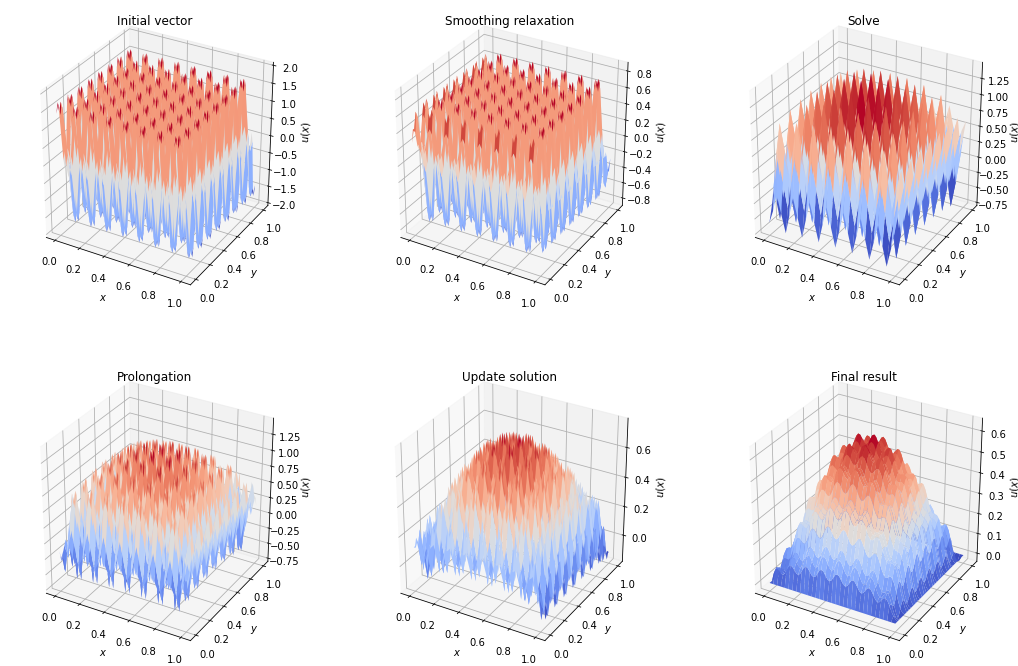

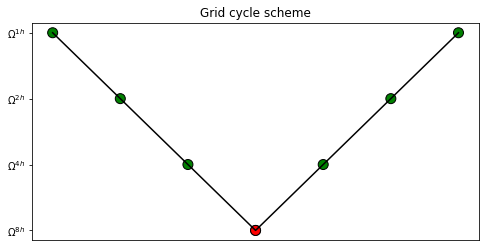

In [16]:
result.show(cycles=True)

W-cycle with 4 levels for anisotropic problem

In [17]:
result2 = tgcyc(
    l=3,
    nsegment=64,
    f = sinx_f,
    u0 = grid_0,
    nu1=10,
    nu2=10,
    gamma=2,
    restriction=injection,
    epsilon = 2,
)

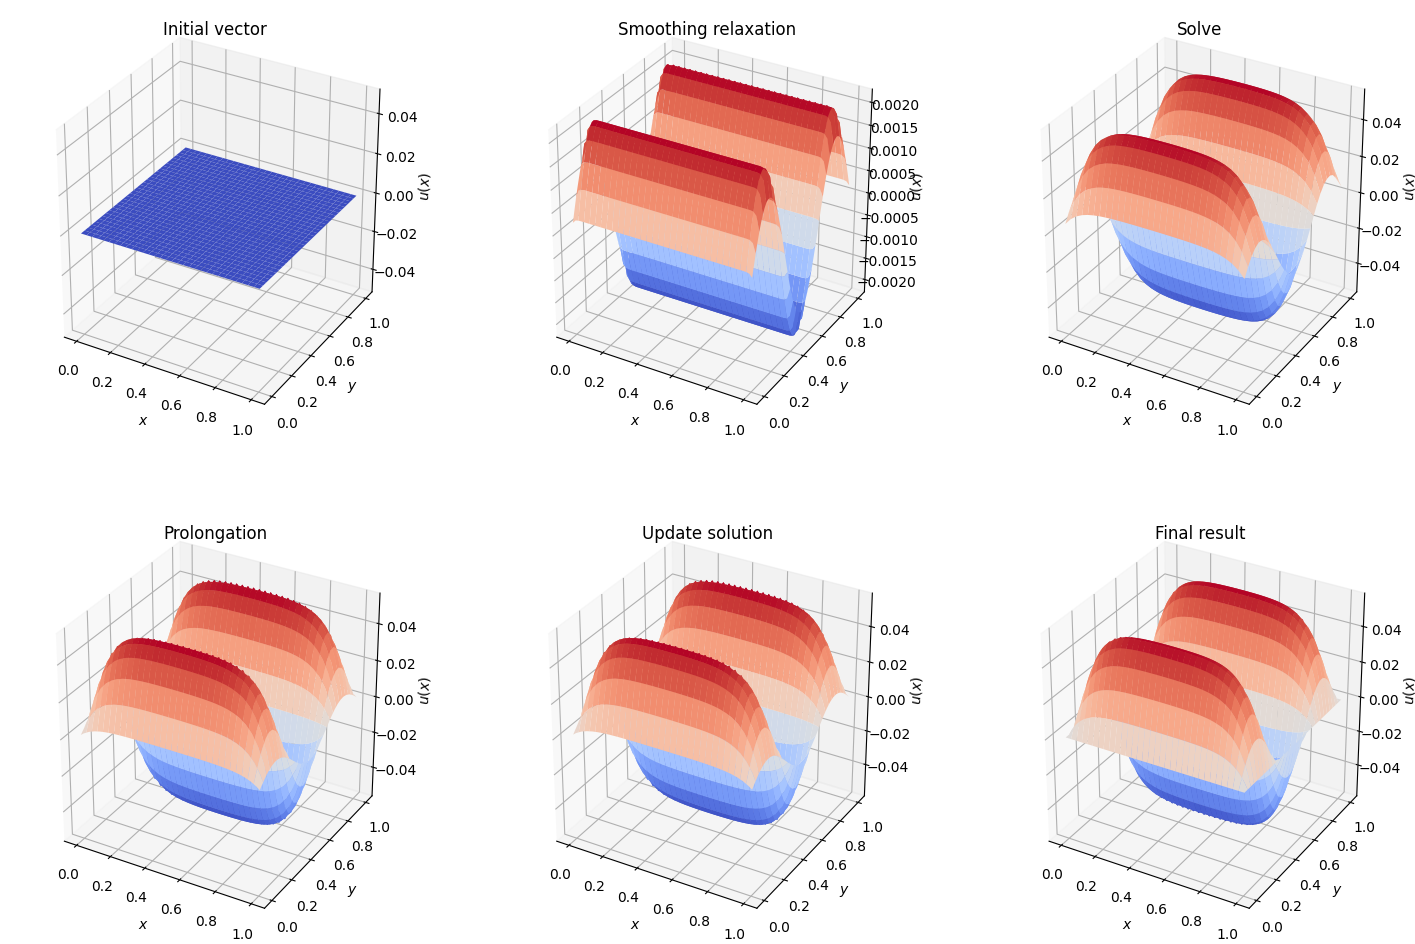

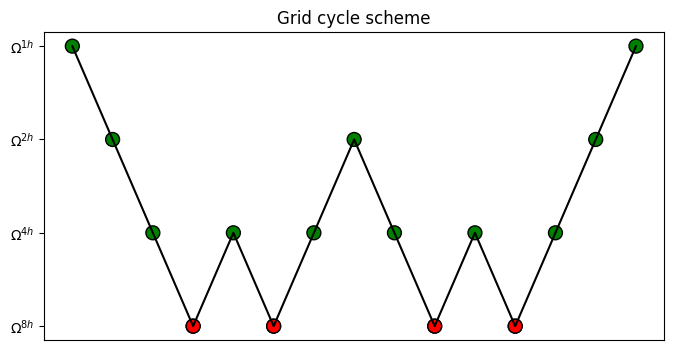

In [18]:
result2.show(cycles=True)

---
Final Multi-grid function to perform multiple iterations

In [13]:
def multigrid(
    l,
    nsegment,
    f,
    engine=JOR,
    nu1=3,
    nu2=3,
    gamma=1,
    tol=0.001,
    restriction=injection,
    **kwargs,
):
    """
    Performs multiple cycles until convergence and stock the residue.
    Parameters:
        tgcyc_recursive parameters
        tol(float): convergence tolerance for the residue
    """
    print(
        f"Simulation with l={l}, nsegment={nsegment}, tol={tol}, gamma={gamma}, "
        + f"engine={engine.__name__}, f={f.__name__}, restriction={restriction.__name__}"
        + (f", sigma={kwargs['sigma']}" if "sigma" in kwargs else "")
        + (f", epsilon={kwargs['epsilon']}" if "epsilon" in kwargs else "")
    )
    start = pf()
    iteration = tgcyc(
        l=l,
        nsegment=nsegment,
        f=f,
        nu1=nu1,
        nu2=nu2,
        gamma=gamma,
        restriction=restriction,
        **kwargs,
    )
    r0 = iteration.res
    result = Result(u0=iteration.display[(0, 0)][0], residues=[1])
    if "u0" in kwargs:
        kwargs.pop("u0")
    duration = pf() - start  # duration for one cycle
    evaluation = True
    while result.residues[-1] > tol:
        iteration = tgcyc(
            l=l,
            nsegment=nsegment,
            f=f,
            u0=iteration.u0,
            nu1=nu1,
            nu2=nu2,
            gamma=gamma,
            restriction=restriction,
            **kwargs,
        )
        result.residues.append(iteration.res / r0)
        if evaluation:
            evaluation = False
            k = result.residues[1] / result.residues[0]
            x = log(tol, k)
            estimated_time = int((x - 1) * duration)
            minutes, seconds = divmod(estimated_time, 60)
            print(f"Estimated time: {minutes} min {seconds} s")

    result.solution = iteration.display[(1, 2)][0]
    return result

---
Convergence analysis single example for a W-cycle of level 4

In [30]:
result = multigrid(
    l=3,
    nsegment=64,
    f = uniform_f,
    u0 = grid_sinxy,
    nu1=2,
    nu2=2,
    gamma=2,
    restriction=full_weighting,
    tol=1e-6,
    sigma = 4,
)

Simulation with l=3, nsegment=64, tol=1e-06, gamma=2, engine=JOR, f=uniform_f, restriction=full_weighting, sigma=4
Estimated time: 0 min 12 s


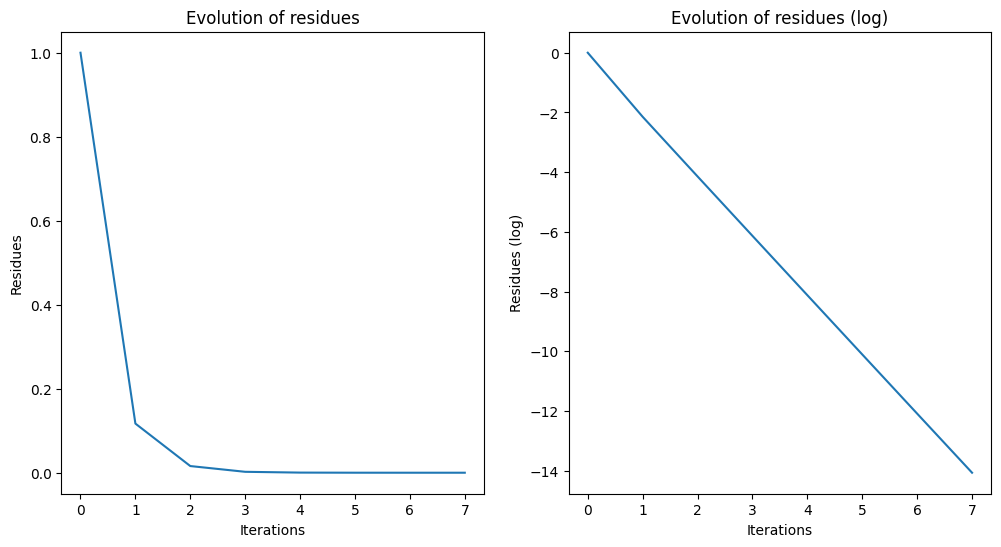

In [31]:
result.show(display=False)

---
## Analysis

### First
Convergence analysis for different resolutions of the system. For different values of $\sigma$ we are going to test the convergence of different cycles (*V* or *W*, depending of $\gamma$) with different levels (parameter *l*).

In [21]:
sigmas = [0.1, 1, 2, 5]
results = {
    key:[multigrid(
      l=l,
      nsegment=64,
      f = uniform_f,
      u0 = grid_sinxy,
      gamma=gamma,
      restriction=full_weighting,
      tol=1e-6,
      sigma = key,  
    )
    for l, gamma in ((1, 1), (2, 1), (3, 1), (2, 2), (3, 2))]  
    for key in sigmas
}


Simulation with l=1, nsegment=64, tol=1e-06, gamma=1, engine=JOR, f=uniform_f, restriction=full_weighting, sigma=0.1
Estimated time: 0 min 14 s
Simulation with l=2, nsegment=64, tol=1e-06, gamma=1, engine=JOR, f=uniform_f, restriction=full_weighting, sigma=0.1
Estimated time: 0 min 16 s
Simulation with l=3, nsegment=64, tol=1e-06, gamma=1, engine=JOR, f=uniform_f, restriction=full_weighting, sigma=0.1
Estimated time: 0 min 16 s
Simulation with l=2, nsegment=64, tol=1e-06, gamma=2, engine=JOR, f=uniform_f, restriction=full_weighting, sigma=0.1
Estimated time: 0 min 15 s
Simulation with l=3, nsegment=64, tol=1e-06, gamma=2, engine=JOR, f=uniform_f, restriction=full_weighting, sigma=0.1
Estimated time: 0 min 15 s
Simulation with l=1, nsegment=64, tol=1e-06, gamma=1, engine=JOR, f=uniform_f, restriction=full_weighting, sigma=1
Estimated time: 0 min 13 s
Simulation with l=2, nsegment=64, tol=1e-06, gamma=1, engine=JOR, f=uniform_f, restriction=full_weighting, sigma=1
Estimated time: 0 min 1

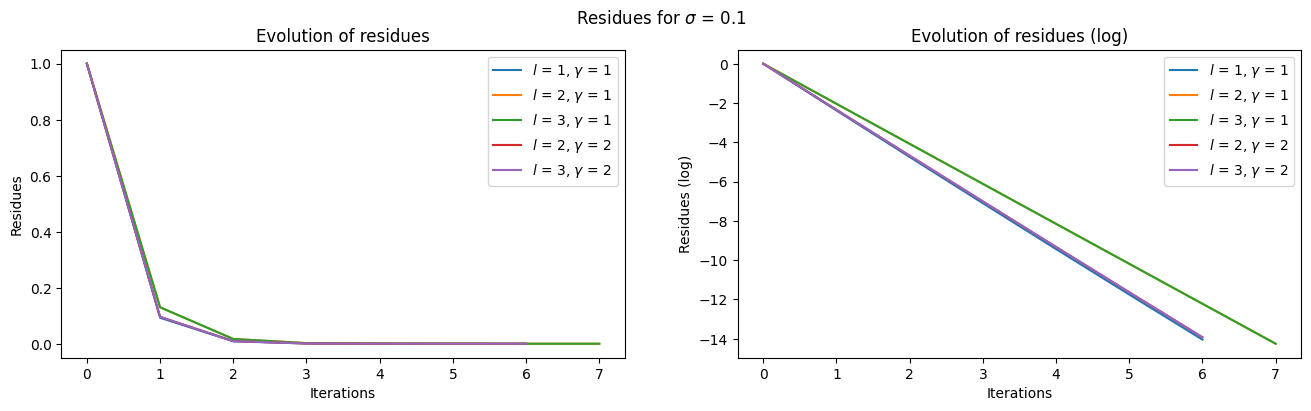

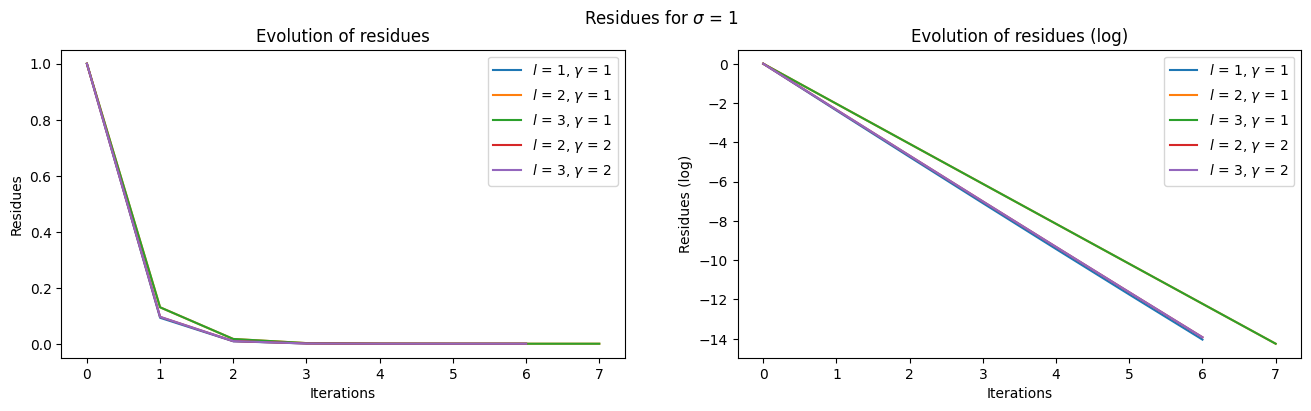

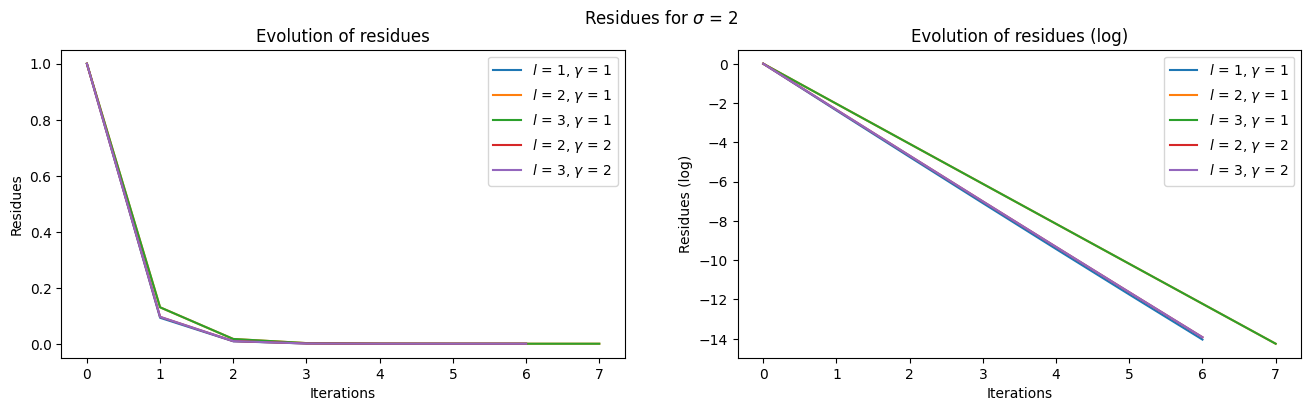

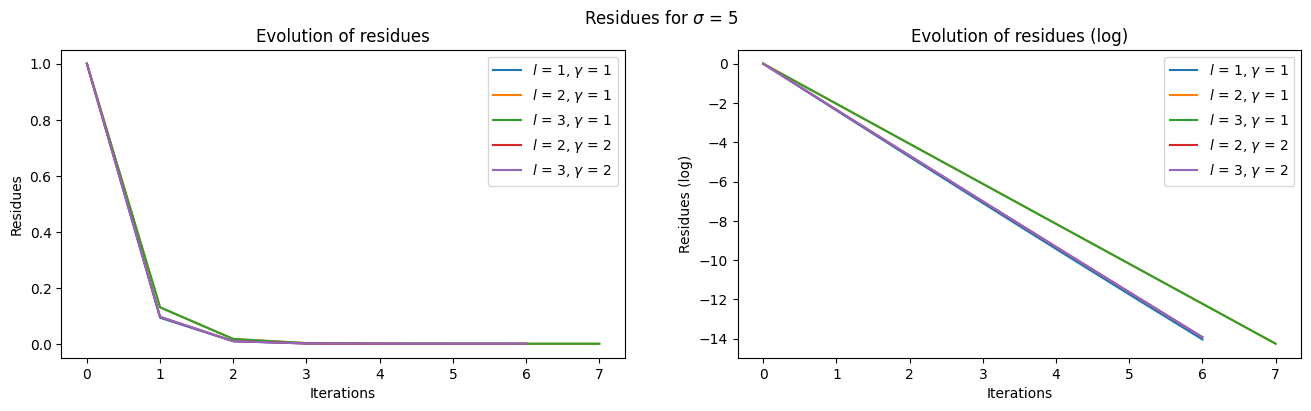

In [22]:
for key in sigmas:
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))
    for result, params in zip(results[key], ((1, 1), (2, 1), (3, 1), (2, 2), (3, 2))):
        result.join(ax, label=f"$l$ = {params[0]}, $\gamma$ = {params[1]}")
    ax[0].set_xlabel("Iterations")
    ax[0].set_ylabel("Residues")
    ax[0].set_title("Evolution of residues")

    ax[1].set_xlabel("Iterations")
    ax[1].set_ylabel("Residues (log)")
    ax[1].set_title("Evolution of residues (log)")

    ax[0].legend()
    ax[1].legend()
    fig.suptitle(f"Residues for $\\sigma$ = {key}")
    plt.show()

The results obtained in this section were different from what expected. From the graphics above, one could conclude that there's is very little difference in convergence from a V-cycle to a W-cycle and its different levels. In reality, tough, the W-cycle converges in less iterations than the V-cycle, despite from its higher computational coast. In addition, deeper level cycles should converge also in less iterations, which could not be observed.

---
### Second
Analysis of the convergence using different injection strategies: normal, half-weighting and full-weighting. All the other parameters remain constant.

In [72]:
sigma = 11
gamma = 2
l = 3
functions = (injection, half_weighting, full_weighting)

restrictions = [multigrid(
    l=l,
    nsegment=64,
    f = uniform_f,
    u0 = grid_sinxy,
    gamma=gamma,
    restriction=func,
    tol=1e-6,
    sigma = sigma,  
) for func in functions]

Simulation with l=3, nsegment=64, tol=1e-06, gamma=2, engine=JOR, f=uniform_f, restriction=injection, sigma=11
Estimated time: 0 min 11 s
Simulation with l=3, nsegment=64, tol=1e-06, gamma=2, engine=JOR, f=uniform_f, restriction=half_weighting, sigma=11
Estimated time: 0 min 11 s
Simulation with l=3, nsegment=64, tol=1e-06, gamma=2, engine=JOR, f=uniform_f, restriction=full_weighting, sigma=11
Estimated time: 0 min 12 s


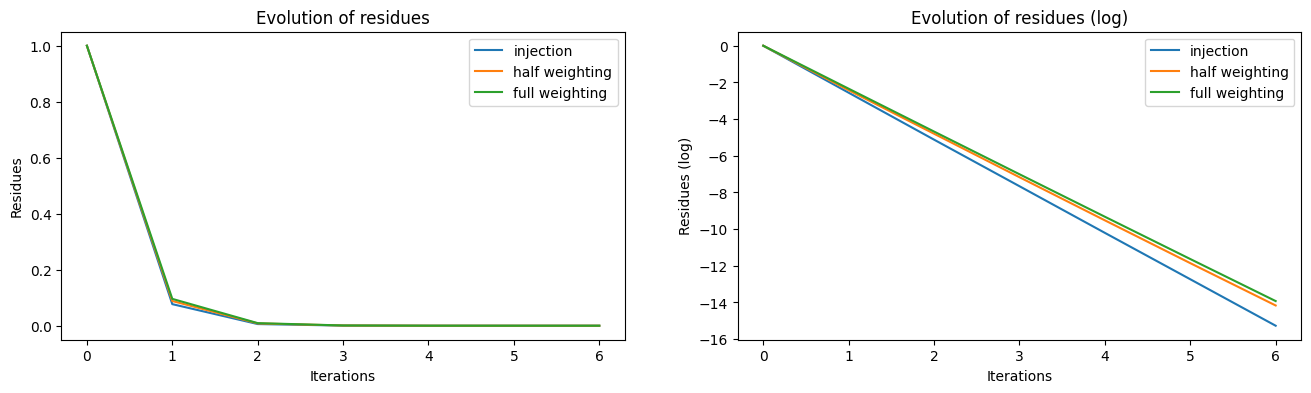

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
for result, params in zip(restrictions, ("injection", "half weighting", "full weighting")):
    result.join(ax, label=params)
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Residues")
ax[0].set_title("Evolution of residues")

ax[1].set_xlabel("Iterations")
ax[1].set_ylabel("Residues (log)")
ax[1].set_title("Evolution of residues (log)")

ax[0].legend()
ax[1].legend()
plt.show()

Here, the differences are also slight. We can observe, tough, that the standard injection method presented a better convergence, followed by the half and full-weighting, which is the contrary of what our group expected.

---
### Third
Analysis of convergence of the anisotropic problem for different values of $\epsilon$, maintaining all other parameters constant.

In [14]:
epsilons = (0.01, 0.1, 1, 10, 50)
gamma = 2
l = 3

anisotropic = [multigrid(
    l=l,
    nsegment=64,
    f = uniform_f,
    u0 = grid_0,
    gamma=gamma,
    restriction=full_weighting,
    tol=1e-2,
    epsilon = ep,  
) for ep in epsilons]

Simulation with l=3, nsegment=64, tol=0.01, gamma=2, engine=JOR, f=uniform_f, restriction=full_weighting, epsilon=0.01
Estimated time: 1 min 12 s
Simulation with l=3, nsegment=64, tol=0.01, gamma=2, engine=JOR, f=uniform_f, restriction=full_weighting, epsilon=0.1
Estimated time: 0 min 22 s
Simulation with l=3, nsegment=64, tol=0.01, gamma=2, engine=JOR, f=uniform_f, restriction=full_weighting, epsilon=1
Estimated time: 0 min 1 s
Simulation with l=3, nsegment=64, tol=0.01, gamma=2, engine=JOR, f=uniform_f, restriction=full_weighting, epsilon=10
Estimated time: 0 min 22 s
Simulation with l=3, nsegment=64, tol=0.01, gamma=2, engine=JOR, f=uniform_f, restriction=full_weighting, epsilon=50
Estimated time: 0 min 58 s


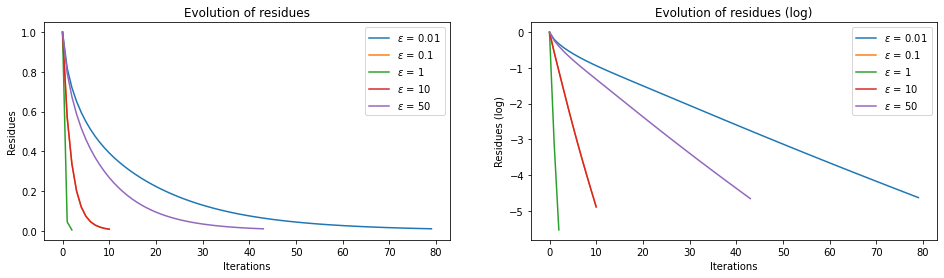

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
for result, params in zip(anisotropic, epsilons):
    result.join(ax, label=f"$\\epsilon$ = {params}")
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Residues")
ax[0].set_title("Evolution of residues")

ax[1].set_xlabel("Iterations")
ax[1].set_ylabel("Residues (log)")
ax[1].set_title("Evolution of residues (log)")

ax[0].legend()
ax[1].legend()
plt.show()

In this problem, we can note that an intermediate value of $\epsilon$ favoured the convergence, since the term $\frac{\partial^2 u(x, y)}{\partial y^2}$ becomes more balanced with the term $\frac{\partial^2 u(x, y)}{\partial x^2}$, thus becoming more similar to the regular Poisson problem. With really large or really small values of $\epsilon$, however, the equation becomes unbalanced and faces convergence problems.

A solution would be to rebalance the equation with a new coarsening strategy, for example a *semi-x approach* , or *semi-y approach*.